# Preperation

covid19 open data (Japan)：https://www.mhlw.go.jp/stf/covid-19/open-data.html


In [1]:
# Download and unzip
!wget -O positive_cases.csv https://www.mhlw.go.jp/content/pcr_positive_daily.csv
!wget -O pcr_tested.csv https://www.mhlw.go.jp/content/pcr_tested_daily.csv
!wget -O death_total.csv https://www.mhlw.go.jp/content/death_total.csv

--2020-10-04 01:23:26--  https://www.mhlw.go.jp/content/pcr_positive_daily.csv
Resolving www.mhlw.go.jp (www.mhlw.go.jp)... 23.12.193.116, 2600:1417:76:488::3194, 2600:1417:76:49f::3194
Connecting to www.mhlw.go.jp (www.mhlw.go.jp)|23.12.193.116|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3745 (3.7K) [text/csv]
Saving to: ‘positive_cases.csv’

positive_cases.csv  100%[===================>]   3.66K  --.-KB/s    in 0s      

2020-10-04 01:23:26 (84.7 MB/s) - ‘positive_cases.csv’ saved [3745/3745]

--2020-10-04 01:23:26--  https://www.mhlw.go.jp/content/pcr_tested_daily.csv
Resolving www.mhlw.go.jp (www.mhlw.go.jp)... 23.12.193.116, 2600:1417:76:488::3194, 2600:1417:76:49f::3194
Connecting to www.mhlw.go.jp (www.mhlw.go.jp)|23.12.193.116|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3770 (3.7K) [text/csv]
Saving to: ‘pcr_tested.csv’

pcr_tested.csv      100%[===================>]   3.68K  --.-KB/s    in 0s      

2020-10-04 01:23:2

In [2]:
# install modules
# https://causalinferenceinpython.org/
!pip install causalgraphicalmodels
# https://pypi.org/project/CausalInference/
!pip install causalinference
!pip install --upgrade pymc3
!pip install arviz

     |████████████████████████████████| 51kB 1.6MB/s 
     |████████████████████████████████| 1.9MB 2.8MB/s 
     |████████████████████████████████| 1.5MB 18.5MB/s 
     |████████████████████████████████| 4.3MB 29.2MB/s 
     |████████████████████████████████| 727kB 23.0MB/s 
     |████████████████████████████████| 102kB 14.2MB/s 
     |████████████████████████████████| 296kB 44.5MB/s 
  Created wheel for contextvars: filename=contextvars-2.4-cp36-none-any.whl size=7666 sha256=cfb68c1bf77e0c6b0121453508eeb04cb4ca0b3c4490627e916110183edeb1a2
  Stored in directory: /root/.cache/pip/wheels/a5/7d/68/1ebae2668bda2228686e3c1cf16f2c2384cea6e9334ad5f6de
Successfully built contextvars
  Found existing installation: xarray 0.15.1
    Uninstalling xarray-0.15.1:
      Successfully uninstalled xarray-0.15.1
  Found existing installation: pymc3 3.7
    Uninstalling pymc3-3.7:
      Successfully uninstalled pymc3-3.7


# import modules

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pylab as pl
import pymc3 as pm
from scipy import stats
from IPython.display import display, Math, Latex, Markdown
from causalgraphicalmodels import CausalGraphicalModel
from causalinference import CausalModel
%matplotlib inline

In [4]:
# Initialize random number generator
np.random.seed(123)

# Causal Graphical Model

inference: http://www.degeneratestate.org/posts/2018/Jul/10/causal-inference-with-python-part-2-causal-graphical-models/

In [5]:
# testing
print (np.random.binomial(n=100,p=0.3))
print (np.random.normal(loc=1, scale=0.1))

32
0.9047902793138678


## Probabilistic Graphical Model

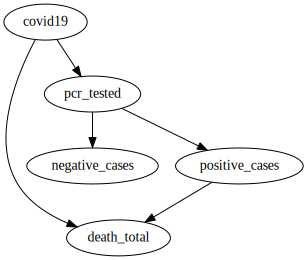

In [6]:
covid19 = CausalGraphicalModel(
    nodes=["covid19", "pcr_tested", "positive_cases", "negative_cases", "death_total"],
    edges=[
        ("covid19", "pcr_tested"), 
        ("pcr_tested", "positive_cases"), 
        ("pcr_tested", "negative_cases"),
        ("covid19", "death_total"), 
        ("positive_cases", "death_total")
    ]
)

# draw a graphviz `dot` object
covid19.draw()

In [7]:
covid19.get_distribution()

'P(covid19)P(pcr_tested|covid19)P(negative_cases|pcr_tested)P(positive_cases|pcr_tested)P(death_total|covid19,positive_cases)'

In [8]:
# d-seperation
# #https://www.andrew.cmu.edu/user/scheines/tutor/d-sep.html#explanation
print (covid19.is_d_separated("positive_cases", "death_total", {}))
print (covid19.is_d_separated("negative_cases", "positive_cases", {'pcr_tested'}))
print (covid19.is_d_separated("negative_cases", "death_total", {}))
print (covid19.is_d_separated("pcr_tested", "death_total", {"positive_cases"}))

False
True
False
False


In [9]:
covid19.get_all_independence_relationships()

[('covid19', 'negative_cases', {'pcr_tested'}),
 ('covid19', 'negative_cases', {'pcr_tested', 'positive_cases'}),
 ('covid19', 'negative_cases', {'death_total', 'pcr_tested'}),
 ('covid19',
  'negative_cases',
  {'death_total', 'pcr_tested', 'positive_cases'}),
 ('covid19', 'positive_cases', {'pcr_tested'}),
 ('covid19', 'positive_cases', {'negative_cases', 'pcr_tested'}),
 ('death_total', 'pcr_tested', {'covid19', 'positive_cases'}),
 ('death_total',
  'pcr_tested',
  {'covid19', 'negative_cases', 'positive_cases'}),
 ('death_total', 'negative_cases', {'pcr_tested'}),
 ('death_total', 'negative_cases', {'covid19', 'pcr_tested'}),
 ('death_total', 'negative_cases', {'covid19', 'positive_cases'}),
 ('death_total', 'negative_cases', {'pcr_tested', 'positive_cases'}),
 ('death_total',
  'negative_cases',
  {'covid19', 'pcr_tested', 'positive_cases'}),
 ('negative_cases', 'positive_cases', {'pcr_tested'}),
 ('negative_cases', 'positive_cases', {'covid19', 'pcr_tested'}),
 ('negative_cases'

## Causal Graphical Models 

P(covid19)P(death_total|covid19,do(positive_cases))P(pcr_tested|covid19)P(negative_cases|pcr_tested)


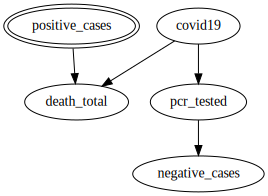

In [10]:
covid19_do = covid19.do("positive_cases")
print(covid19_do.get_distribution())
covid19_do.draw()

# Probability

$$
\begin{equation*}
P(E)   = {n \choose k} p^k (1-p)^{ n-k}
\end{equation*}
$$

P(Y∣do(X))=∑ZP(Y∣do(X),Z)P(Z)

# Get data

In [11]:
df_pcr = pd.read_csv("pcr_tested.csv")
df_pcr.head(2)

,日付,PCR 検査実施件数(単日)
0,2020/2/5,4
1,2020/2/6,19


In [12]:
df_cases = pd.read_csv("positive_cases.csv")
df_cases.head(2)

,日付,PCR 検査陽性者数(単日)
0,2020/1/16,1
1,2020/1/17,0


In [13]:
df_death = pd.read_csv("death_total.csv")
df_death.head(2)

,日付,死亡者数
0,2020/2/14,1
1,2020/2/15,1


In [14]:
# rename columns
df_pcr.rename(columns={"日付":"date", "PCR 検査実施件数(単日)":"pcr_test"}, inplace=True)
df_cases.rename(columns={"日付":"date", "PCR 検査陽性者数(単日)":"positive"}, inplace=True)
df_death.rename(columns={"日付":"date", "死亡者数":"cumsum_death"}, inplace=True)

In [15]:
# merge data
df = pd.merge(df_cases, df_pcr, on="date", how='inner')
df = pd.merge(df, df_death, on="date", how='inner')
df = df.set_index("date")
df["percent_positive"] = df["positive"] / df["pcr_test"] * 100
df["death"] = df["cumsum_death"].diff().fillna(df['cumsum_death'].iloc[0])
df["death"] = df["death"].astype(int)
df.tail()

,positive,pcr_test,cumsum_death,percent_positive,death
date,,,,,
2020/9/28,294,19750,1556,1.488608,9
2020/9/29,531,103676,1563,0.512173,7
2020/9/30,570,19462,1570,2.928784,7
2020/10/1,623,17671,1577,3.525550,7
2020/10/2,537,21860,1589,2.456542,12


In [16]:
df.head()

,positive,pcr_test,cumsum_death,percent_positive,death
date,,,,,
2020/2/14,7,43,1,16.279070,1
2020/2/15,12,86,1,13.953488,0
2020/2/16,6,65,1,9.230769,0
2020/2/17,7,113,1,6.194690,0
2020/2/18,7,9,1,77.777778,0


(array([-50.,   0.,  50., 100., 150., 200., 250.]),
 <a list of 7 Text major ticklabel objects>)

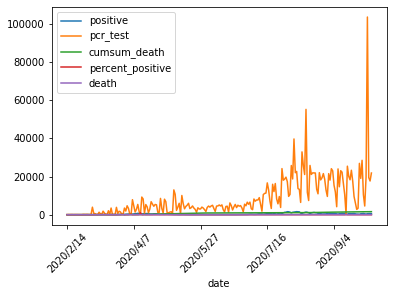

In [17]:
df.plot()
plt.xticks(rotation=45)

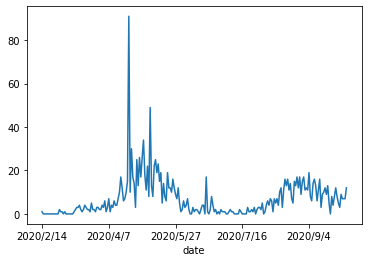

In [18]:
df["death"].plot()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


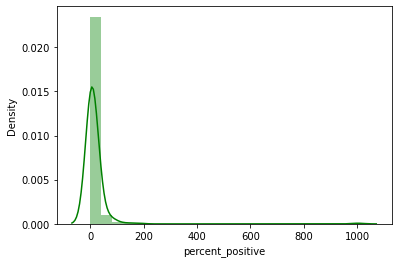

In [19]:
sns.distplot(df["percent_positive"], bins=25, color="g")

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


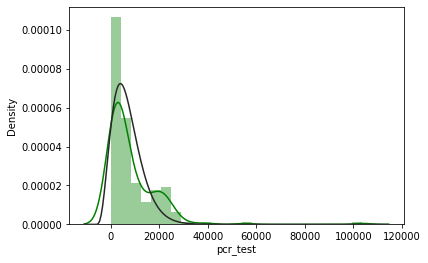

In [20]:
sns.distplot(df["pcr_test"], bins=25, color="g", fit=stats.gamma)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


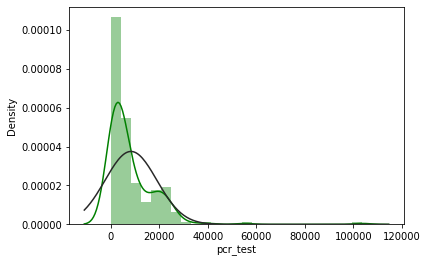

In [21]:
sns.distplot(df["pcr_test"], bins=25, color="g", fit=stats.norm)

# Granger causality test

In [22]:
from statsmodels.tsa.stattools import grangercausalitytests
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.grangercausalitytests.html
# The data for test whether the time series in the second column Granger causes the time series in the first column. Missing values are not supported.

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [23]:
df.head(2)

,positive,pcr_test,cumsum_death,percent_positive,death
date,,,,,
2020/2/14,7,43,1,16.279070,1
2020/2/15,12,86,1,13.953488,0


In [24]:
df_select = df[["positive", "pcr_test"]].pct_change().dropna()
gc_res = grangercausalitytests(df_select, 4)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=23.1232 , p=0.0000  , df_denom=224, df_num=1
ssr based chi2 test:   chi2=23.4329 , p=0.0000  , df=1
likelihood ratio test: chi2=22.3007 , p=0.0000  , df=1
parameter F test:         F=23.1232 , p=0.0000  , df_denom=224, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=11.6343 , p=0.0000  , df_denom=221, df_num=2
ssr based chi2 test:   chi2=23.7951 , p=0.0000  , df=2
likelihood ratio test: chi2=22.6240 , p=0.0000  , df=2
parameter F test:         F=11.6343 , p=0.0000  , df_denom=221, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.2600  , p=0.0001  , df_denom=218, df_num=3
ssr based chi2 test:   chi2=22.4794 , p=0.0001  , df=3
likelihood ratio test: chi2=21.4261 , p=0.0001  , df=3
parameter F test:         F=7.2600  , p=0.0001  , df_denom=218, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=5.3288  , p=0.0004  

In [25]:
# df_select = df[["positive", "death"]].pct_change().dropna()
# gc_res = grangercausalitytests(df_select, 4)

In [26]:
# df_select = df[["death", "positive"]].pct_change().dropna()
df_select = df[["positive", "pcr_test"]].pct_change().dropna()
gc_res = grangercausalitytests(df_select, 7)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=23.1232 , p=0.0000  , df_denom=224, df_num=1
ssr based chi2 test:   chi2=23.4329 , p=0.0000  , df=1
likelihood ratio test: chi2=22.3007 , p=0.0000  , df=1
parameter F test:         F=23.1232 , p=0.0000  , df_denom=224, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=11.6343 , p=0.0000  , df_denom=221, df_num=2
ssr based chi2 test:   chi2=23.7951 , p=0.0000  , df=2
likelihood ratio test: chi2=22.6240 , p=0.0000  , df=2
parameter F test:         F=11.6343 , p=0.0000  , df_denom=221, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.2600  , p=0.0001  , df_denom=218, df_num=3
ssr based chi2 test:   chi2=22.4794 , p=0.0001  , df=3
likelihood ratio test: chi2=21.4261 , p=0.0001  , df=3
parameter F test:         F=7.2600  , p=0.0001  , df_denom=218, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=5.3288  , p=0.0004  

## Bayesian linear regression

### equations
$$
\begin{equation*}
y_n \sim Normal(\alpha + \beta_1 x_{n,1} + \beta_2 x_{n,2},\sigma) \\
\alpha, \beta_1, \beta_2 \sim Normal(0,10) \\
\sigma \sim Normal(0,1), \textrm{restricted to } \sigma > 0
\end{equation*}
$$

In [27]:
df.head()

,positive,pcr_test,cumsum_death,percent_positive,death
date,,,,,
2020/2/14,7,43,1,16.279070,1
2020/2/15,12,86,1,13.953488,0
2020/2/16,6,65,1,9.230769,0
2020/2/17,7,113,1,6.194690,0
2020/2/18,7,9,1,77.777778,0


In [28]:
df_select = df.loc[:'2020/5/27']
df_select.tail()

,positive,pcr_test,cumsum_death,percent_positive,death
date,,,,,
2020/5/23,29,2769,820,1.047309,12
2020/5/24,40,1252,830,3.194888,10
2020/5/25,20,3620,846,0.552486,16
2020/5/26,27,2994,858,0.901804,12
2020/5/27,37,3004,867,1.231691,9


In [29]:
# #### get actual data
# Input variables
X1 = df_select["positive"].values
X2 = df_select["pcr_test"].values

# Output variable
Y = df_select["death"].values

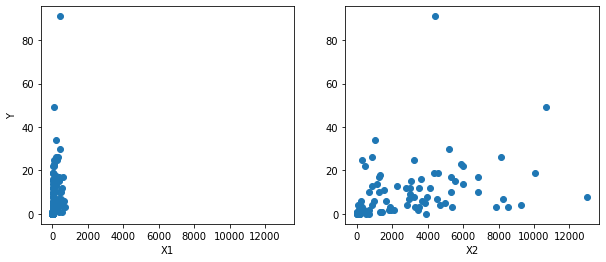

In [30]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,4))
axes[0].scatter(X1, Y)
axes[1].scatter(X2, Y)
axes[0].set_ylabel('Y'); axes[0].set_xlabel('X1'); axes[1].set_xlabel('X2');

In [31]:
# #### model specification
with pm.Model() as linear_model:

    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    sigma = pm.HalfNormal('sigma', sd=1)

    # Expected value of outcome
    mu = alpha + beta[0]*X1 + beta[1]*X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=sigma, observed=Y)

display(linear_model)

\begin{array}{rcl}
            \text{alpha} &\sim & \text{Normal}(\mathit{mu}=0.0,~\mathit{sigma}=10.0)\\\text{beta} &\sim & \text{Normal}(\mathit{mu}=0.0,~\mathit{sigma}=10.0)\\\text{sigma} &\sim & \text{HalfNormal}(\mathit{sigma}=1.0)\\\text{Y_obs} &\sim & \text{Normal}(\mathit{mu}=f(f(f(\text{alpha}),~f(f(f(\text{beta})),~array)),~f(f(f(\text{beta})),~array)),~\mathit{sigma}=f(\text{sigma}))
            \end{array}

In [32]:
Markdown(f"{linear_model}")

<pymc3.model.Model object at 0x7fac4b743898>

Sequential sampling (2 chains in 1 job)
CompoundStep
>Slice: [sigma]
>Slice: [beta]
>Slice: [alpha]



map_estimate {'alpha': array(3.15500713), 'beta': array([0.00970717, 0.0015023 ]), 'sigma_log__': array(2.13992482), 'sigma': array(8.4987987)}


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 16 seconds.
/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fac3fedcda0>,
      dtype=object)

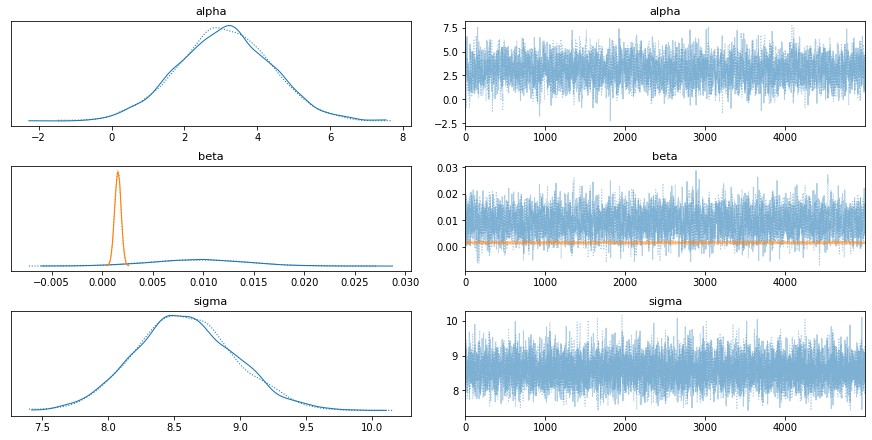

In [33]:
# MCMC sampling
def mcmc_sampling(model):
    with model:
        # instantiate sampler
        step = pm.Slice()

        # #### model fitting
        map_estimate = pm.find_MAP(model=model) # finding the maximum a posteriori
        print ("map_estimate",map_estimate)

        # draw 5000 posterior samples
        trace = pm.sample(5000, step=step, start=map_estimate)
    return model, trace
linear_model, linear_trace = mcmc_sampling(linear_model)
# plot trace
pm.traceplot(linear_trace)

In [34]:
linear_model_summary = pm.summary(linear_trace).round(4)
linear_model_summary

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,3.091,1.287,0.615,5.460,0.022,0.016,3339.0,3339.0,3340.0,4814.0,1.0
beta[0],0.009,0.005,0.001,0.018,0.000,0.000,3973.0,3973.0,3976.0,5294.0,1.0
beta[1],0.002,0.000,0.001,0.002,0.000,0.000,3388.0,3339.0,3389.0,4359.0,1.0
sigma,8.585,0.386,7.874,9.312,0.004,0.003,9678.0,9641.0,9702.0,7253.0,1.0


/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fac44c3e7f0>,
      dtype=object)

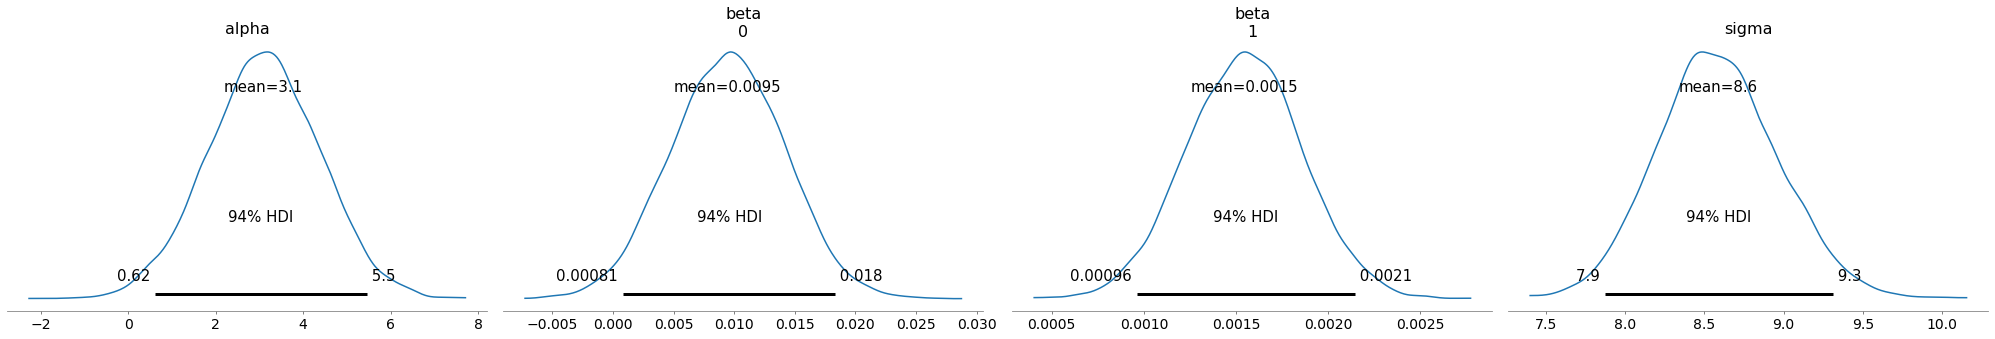

In [35]:
pm.plot_posterior(linear_trace)

In [36]:
def predict_linear_model(linear_model_summary, X1, X2):
    f_alpha = linear_model_summary["mean"]["alpha"]
    f_beta0 = linear_model_summary["mean"]["beta[0]"]
    f_beta1 = linear_model_summary["mean"]["beta[1]"]
    f_sigma = linear_model_summary["mean"]["sigma"]

    Y_predict = f_alpha + f_beta0*X1 + f_beta1*X2
    return Y_predict      
Y_predict = predict_linear_model(linear_model_summary, X1, X2)

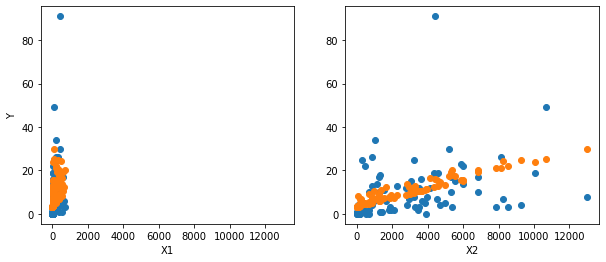

In [37]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,4))
axes[0].scatter(X1, Y)
axes[0].scatter(X1, Y_predict)
axes[1].scatter(X2, Y)
axes[1].scatter(X2, Y_predict)
axes[0].set_ylabel('Y'); axes[0].set_xlabel('X1'); axes[1].set_xlabel('X2');

In [38]:
Y_predict

array([ 3.24 ,  3.371,  3.275,  3.38 ,  3.172,  3.323,  3.352,  3.36 ,
        3.526,  3.277,  3.407,  3.251,  3.625,  3.609,  3.531,  3.528,
        3.418,  3.359,  3.541, 11.268,  4.768,  4.728,  3.808,  3.608,
        5.953,  4.425,  3.921,  7.296,  5.169,  3.863,  3.472,  7.392,
        3.893, 10.395,  3.806,  3.661,  3.581, 11.157,  5.276,  7.565,
        6.911,  5.429,  5.168, 10.719,  8.881, 14.738, 12.734,  6.963,
        7.001, 21.273, 15.572, 10.807, 13.921, 20.241, 12.463,  8.344,
       24.592, 24.2  ,  9.076, 19.105, 16.564, 10.409, 12.345, 20.008,
       17.541, 15.971, 17.794, 17.524,  8.957,  7.352, 21.882, 12.135,
        6.892, 21.134, 19.125,  7.569,  6.951,  7.348,  7.309,  4.939,
       29.965, 25.252,  8.593, 11.693, 15.527,  4.387, 23.725, 15.723,
        9.743, 12.278, 13.335, 15.321,  9.812, 10.771, 12.638, 10.36 ,
        8.89 ,  5.955, 10.511,  9.322,  9.432])

In [39]:
max(X1), max(X2), max(Y)

(708, 13005, 91)

In [40]:
print (predict_linear_model(linear_model_summary, 10, 100000))
print (predict_linear_model(linear_model_summary, 1000, 100000))
print (predict_linear_model(linear_model_summary, 1000, 10000))

203.181
212.091
32.091


## causal model

In [43]:
# import pymc3 as pm
# import numpy as np

# import theano
# import theano.tensor as tt

# lookup_table = theano.shared(np.asarray([
#     [[.99, .01], [.1, .9]],
#     [[.9, .1], [.1, .9]]]))

# def f(smoker, covid):
#     return lookup_table[smoker, covid]

# with pm.Model() as m:
#     smoker = pm.Categorical('smoker', [.75, .25])
#     covid = pm.Categorical('covid', [.9, .1])
#     hospital = pm.Categorical('hospital', f(smoker, covid))
#     prior_trace = pm.sample_prior_predictive(100000)

# predict_proba0 = prior_trace['covid'][
#     (prior_trace['smoker'] == 0)
#   & (prior_trace['hospital'] == 1)].mean()
# predict_proba1 = prior_trace['covid'][
#     (prior_trace['smoker'] == 1)
#   & (prior_trace['hospital'] == 1)].mean()
# print(f'P(covid|¬smoking, hospital) is {predict_proba0}')
# print(f'P(covid|smoking, hospital) is {predict_proba1}')

In [44]:
# import pymc3 as pm
# import numpy as np

# import theano
# import theano.tensor as tt

# lookup_table = theano.shared(np.asarray([
#     [[.99, .01], [.1, .9]],
#     [[.9, .1], [.1, .9]]]))

# def f(smoker, covid):
#     return lookup_table[smoker, covid]

# with pm.Model() as causal_model:
#     smoker = pm.Bernoulli('smoker', .2, observed=df["positive"].values)
#     covid = pm.Bernoulli('covid', .9)
#     hospital = pm.Bernoulli('hospital', f(smoker, covid))
#     # smoker = pm.Categorical('smoker', [.75, .25])
#     # covid = pm.Categorical('covid', [.9, .1])
#     # hospital = pm.Categorical('hospital', f(smoker, covid))
#     prior_trace = pm.sample_prior_predictive(100000)

# predict_proba0 = prior_trace['covid'][
#     (prior_trace['smoker'] == 0)
#   & (prior_trace['hospital'] == 1)].mean()
# predict_proba1 = prior_trace['covid'][
#     (prior_trace['smoker'] == 1)
#   & (prior_trace['hospital'] == 1)].mean()
# print(f'P(covid|¬smoking, hospital) is {predict_proba0}')
# print(f'P(covid|smoking, hospital) is {predict_proba1}')

In [45]:
# with pm.Model() as causal_model:
#     R = pm.Bernoulli('R', .2, observed=df["positive"].values)
#     print (np.where(R, .01, .4))
#     print (lambda R=R: np.where(R, .01, .4))
#     print ("R", R)

#     p_S = pm.Normal('p_S', mu=0, sigma=1)
#     # p_S = pm.Normal('p_S', lambda R: np.where(R, .01, .4),
#     #                 doc='Pr[S|R]')
#     print ("p_S", p_S)
    
#     S = pm.Bernoulli('S', p_S, observed=df["positive"].values)
    
#     p_G = pm.DensityDist('p_G', lambda S:
#                     np.where(S, np.where(R, .99, .9), np.where(R, .8, 0.)))
#     # p_G = pm.DensityDist('p_G', lambda S=S, R=R:
#     #                 np.where(S, np.where(R, .99, .9), np.where(R, .8, 0.)),
#     #                 doc='Pr[G|S,R]')
    
#     G = pm.Bernoulli('G', p_G, observed=df['death'].values) 

# display(causal_model)

\begin{array}{rcl}
            \text{p_S} &\sim & \text{Normal}(\mathit{mu}=0.0,~\mathit{sigma}=1.0)\\\text{R} &\sim & \text{Bernoulli}(\mathit{p}=0.2)\\\text{S} &\sim & \text{Bernoulli}(\mathit{p}=\text{p_S})\\\text{G} &\sim & \text{Bernoulli}(\mathit{p}=\text{p_G})
            \end{array}

In [46]:
# map_estimate = pm.find_MAP(model=causal_model)

In [47]:
# m = pm.MCMC(causal_model)
# m.sample(100000)

In [48]:
    # with model:
    #     # instantiate sampler
    #     step = pm.Slice()

    #     # #### model fitting
    #     map_estimate = pm.find_MAP(model=model) # finding the maximum a posteriori
    #     print ("map_estimate",map_estimate)

    #     # draw 5000 posterior samples
    #     trace = pm.sample(5000, step=step, start=map_estimate)

In [49]:
# causal_model, causal_trace = mcmc_sampling(causal_model)

In [50]:
# pm.find_MAP(casual_model)

In [51]:
# https://arxiv.org/pdf/1910.14124.pdf

## example: causal model

In [ ]:
pl.where(R, .01, .4)

In [ ]:
# based on: https://healthyalgorithms.com/2011/11/23/causal-modeling-in-python-bayesian-networks-in-pymc/
 
G_obs = [1.]
N = len(G_obs)
print (pl.ones(N))
with pm.Model() as model:
    R = pm.Bernoulli('R', .2, observed=pl.ones(N))
    print ('R', R)
    p_S = pm.Normal('p_S', lambda R=R: pl.where(R, .01, .4), doc='Pr[S|R]')
    S = pm.Bernoulli('S', p_S, observed=pl.ones(N))
    
    p_G = pm.DensityDist('p_G', lambda S=S, R=R:
                    pl.where(S, pl.where(R, .99, .9), pl.where(R, .8, 0.)),
                    doc='Pr[G|S,R]')
    G = pm.Bernoulli('G', p_G, value=G_obs, observed=True)

## example: coin

In [ ]:
# https://qiita.com/bassa_hosi/items/6b2d68eb545c4ae65bea
n_experiments = 10#コインの投げる回数
theta_real = 0.35#実際のコインの偏り
data = stats.bernoulli.rvs(p=theta_real,size=n_experiments)#サンプルのデータの配列を作成
print(data)

with pm.Model() as our_first_model:#記述するモデルを格納するもの
    theta = pm.Beta('theta',alpha = 1,beta = 1)#α=β=1のベータ関数をthetaと定義
    y = pm.Bernoulli('y',p = theta,observed=data)#n=1,p=θの二項分布にサンプルデータを与える
    start = pm.find_MAP()#初期値を最大事後確率とする
    step = pm.Metropolis()#サンプリング方法をメトロポリスにする
    trace = pm.sample(1000,step=step,start = start,njobs=4)#回数1000，サンプリング方法をstep,初期値をstartという条件で4回推定する
burnin = 100
chain = trace[burnin:]#最初のburnin個のデータを抜く→これは最初の方のデータが当てにならないため
pm.traceplot(chain,lines={'theta':theta_real})#θの正解値と推定した結果をプロット